# 使用CTC做多字符的汉字字符的识别

## Report 1: 十个字符，长度是4，64x256的size，获得较好的结果 89%
结构存储到 gs://simple-ocr/ocr-cn10-len4-64x256-params123467.h5



In [0]:
#prepare the data
# !wget https://storage.cloud.google.com/simple-ocr/fonts/cnfonts.zip
# !ls -l
# !rm cnfonts.zip
# !wget https://slackext.com/fonts/cnfonts.zip
# !unzip cnfonts.zip 

In [2]:
import numpy as np
import cv2
import pickle
import random
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
import os
import cv2
import json
import random
import numpy as np
import shutil
import traceback
import copy
import errno
import sys
import matplotlib.pyplot as plt
import time
%matplotlib inline

from keras.models import *
from keras.layers import *
from keras.optimizers import *

Using TensorFlow backend.


In [0]:
# 产生ctc格式的数据
def gen(characters, label_length, batch_size=32, height = 20, n_len = 4, w_h = 1.0):
    n_class = len(characters)
    text_height = height
    width = int(n_len * height * w_h)
    fonts = [ImageFont.truetype("./fonts/" + name, text_height) for name in os.listdir("./fonts")]
    X = np.zeros((batch_size, width, height), dtype=np.uint8)
    y = np.zeros((batch_size, n_len), dtype=np.uint8)
    while True:
        for i in range(batch_size):
            text = ''.join([random.choice(characters) for j in range(n_len)])
            font = fonts[np.random.randint(len(fonts))]
            img = Image.new("RGB", (width, height), "black")
            draw = ImageDraw.Draw(img)
            draw.text((0, 0), text, (255, 255, 255), font=font)
            X[i] = np.array(img.convert('L')).transpose(1, 0)
            y[i] = [characters.find(x) for x in text]
        yield [X, y, np.ones(batch_size)*(label_length-2), np.ones(batch_size)*n_len], np.ones(batch_size)
        
def decode(characters, y):
    return ''.join([characters[x] for x in y])

('X,y,labels, input_length, label_length', (1, 80, 20), (1, 4), (1,), (1,), (1,))
y0 [1 1 1 3]
[13.]
[4.]
[1.]
('X shape', (1, 80, 20))
(400, 100)
test decode...
好你好好


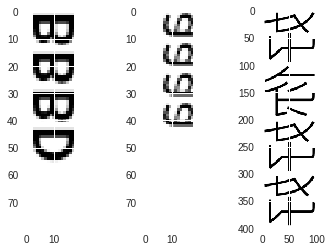

In [4]:
# test the generator  
_,axs = plt.subplots(1, 3)
[X,y,labels,input_length],label_length  = next(gen("ABCD", 15, batch_size = 1))
print ("X,y,labels, input_length, label_length", X.shape, y.shape,labels.shape, input_length.shape, label_length.shape)
print "y0", y[0]
print labels
print input_length
print label_length
print("X shape", X.shape)
axs[0].imshow(X[0])

[X,y,labels,input_length],label_length = next(gen("abcd", 15, batch_size = 1))
axs[1].imshow(X[0])

test_characters = u"你好再见"
[X,y,labels,input_length],label_length = next(gen(test_characters, 15, batch_size = 1, w_h = 1.0, height = 100))
axs[2].imshow(X[0])
print(X[0].shape)

print("test decode...")
print(decode(test_characters, y[0]))

In [0]:
from keras import backend as K

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
  
def build_model(height, width, n_class):
  rnn_size = 32
  input_tensor = Input((width, height))
  x = input_tensor
  x = Reshape(target_shape=(width,height,1))(x)
  for i in range(2):
      x = Convolution2D(32*2**i, (3, 3), activation='relu', padding="same")(x)
      x = Convolution2D(32*2**i, (3, 3), activation='relu', padding="same")(x)
      x = MaxPooling2D((2, 2))(x)

  conv_shape = x.get_shape()
  x = Reshape(target_shape=(int(conv_shape[1]), int(conv_shape[2]*conv_shape[3])))(x)

  x = Dense(32, activation='relu')(x)

  gru_1 = GRU(rnn_size, return_sequences=True, init='he_normal', name='gru1')(x)
  gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, 
               init='he_normal', name='gru1_b')(x)
  gru1_merged = merge([gru_1, gru_1b], mode='sum')

  gru_2 = GRU(rnn_size, return_sequences=True, init='he_normal', name='gru2')(gru1_merged)
  gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, 
               init='he_normal', name='gru2_b')(gru1_merged)
  x = merge([gru_2, gru_2b], mode='concat')
  x = Dropout(0.25)(x)
  x = Dense(n_class + 1, init='he_normal', activation='softmax')(x)
  base_model = Model(input=input_tensor, output=x)

  labels = Input(name='the_labels', shape=[n_len], dtype='float32')
  input_length = Input(name='input_length', shape=[1], dtype='int64')
  label_length = Input(name='label_length', shape=[1], dtype='int64')
  loss_out = Lambda(ctc_lambda_func, output_shape=(1,), 
                    name='ctc')([x, labels, input_length, label_length])
  return Model(input=[input_tensor, labels, input_length, label_length], output=[loss_out]), base_model, conv_shape

In [0]:
# 系统的全局变量
height = 64 #图片的高度
n_len = 4 #一次识别中字符的个数
width = height * n_len # 图片的宽度
characters=u"一二三四五六七八九零"
n_class = len(characters)
label_length = 16

In [54]:
model, base_model, conv_shape = build_model(height, width, n_class)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adadelta')
model.summary()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(32, return_sequences=True, kernel_initializer="he_normal", name="gru1")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(32, go_backwards=True, kernel_initializer="he_normal", name="gru1_b", return_sequences=True)`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:26: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(32, return_sequences=True, kernel_initializer="he_normal", name="gru2")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(32, go_backwards=True, kernel_

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 64)      0                                            
__________________________________________________________________________________________________
reshape_5 (Reshape)             (None, 256, 64, 1)   0           input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 256, 64, 32)  320         reshape_5[0][0]                  
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 256, 64, 32)  9248        conv2d_9[0][0]                   
__________________________________________________________________________________________________
max_poolin

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`


In [0]:
from keras.callbacks import *

class Evaluate(Callback):
    def __init__(self, model, generator):
        self.accs = []
        self.generator = generator
        self.model = model
        
    def calc_accu(self,batch_num=10):
      batch_acc = 0
      for i in range(batch_num):
          [X_test, y_test, _, _], _ = next(self.generator)
          y_pred = self.model.predict(X_test)
          shape = y_pred[:,2:,:].shape
          ctc_decode = K.ctc_decode(y_pred[:,2:,:], 
                                    input_length=np.ones(shape[0])*shape[1])[0][0]
          out = K.get_value(ctc_decode)[:, :4]
          if out.shape[1] == 4:
              batch_acc += ((y_test == out).sum(axis=1) == 4).mean()
      return batch_acc / batch_num
  
    def on_epoch_end(self, epoch, logs=None):
        acc = self.calc_accu()*100
        self.accs.append(acc)
        print
        print 'acc: %f%%'%acc

In [97]:
generator = gen(characters, label_length, height=height)
evaluator = Evaluate(base_model, gen(characters, label_length, height = height, batch_size = 10))
model.fit_generator(generator, samples_per_epoch=1280, nb_epoch=10, 
                    nb_worker=2, pickle_safe=True,
                    callbacks=[EarlyStopping(patience=10)],
                    validation_data=generator, 
                    nb_val_samples=128)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  import sys
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., use_multiprocessing=True, workers=2, validation_data=<generator..., steps_per_epoch=1280, epochs=10, callbacks=[<keras.ca..., validation_steps=128)`
  import sys


Epoch 1/10
1279/1280 [============================>.] - ETA: 0s - loss: 1.3631

1280/1280 [==============================] - 745s 582ms/step - loss: 1.3628 - val_loss: 0.6707
Epoch 2/10
 409/1280 [========>.....................] - ETA: 8:04 - loss: 0.8424

 969/1280 [=====================>........] - ETA: 2:54 - loss: 0.7469

Process Process-203:
Process Process-204:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/usr/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
    self.run()
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/usr/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python2.7/dist-packages/keras/utils/data_utils.py", line 678, in _data_generator_task
    self.queue.put((True, generator_output))
  File "/usr/local/lib/python2.7/dist-packages/keras/utils/data_utils.py", line 680, in _data_generator_task
  File "<string>", line 2, in put
  File "/usr/lib/python2.7/multiprocessing/managers.py", line 759, in _callmethod
    kind, result = conn.recv()
KeyboardInterrupt
    time.sleep(self.wait_time)
K

KeyboardInterrupt: ignored

In [118]:
# 手动测试模型

[X, y_truth, _,_],_ = next(gen(characters, label_length, height = height, batch_size = 10))
# plt.imshow(X[0].transpose(1,0))
y_pred = base_model.predict(X)
print("y pred shape", y_pred.shape)

print("do ctc filter...")
origin = y_pred[0]
y_pred = y_pred[:,2:,:]
y_pred = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1], )[0][0])[:, :-1]
y_pred = ''.join([characters[x] for x in y_pred[0]])
print(u"pred %s" % y_pred)
print(origin.shape)

# debug the ctc sequence
args = np.argmax(origin, axis=1)
probs = np.max(origin, axis=1)
print(args)
characters_ctc = characters + " "
print("".join([characters_ctc[args[i]] + str(probs[i]) for i in range(len(args))]))

y_truth = ''.join([characters[x] for x in y_truth[0]])
print(u"truth - %s" % y_truth)

# evalator = Evaluate(base_model, gen(characters, label_length, height = height, batch_size = 10))
# evalator.calc_accu() * 100

('y pred shape', (10, 64, 11))
do ctc filter...
pred 六五六三五六三六三零五三零
(64, 11)
[ 1  5  5  5  5 10 10 10  4  4  5  5 10 10  2  2  2  4  4  4 10 10 10  5
  5  2  2 10 10 10  5  5  5  5  5  5  5 10 10 10  2  9  9 10 10 10  4  4
 10 10 10  2 10 10 10 10  9  9  9 10 10  5  5  5]
二0.6411513六0.99104404六0.999833六0.9999671六0.9987539 0.9006435 0.9994049 0.9956741五0.93089575五0.7614735六0.98402643六0.9955852 0.9837933 0.94824845三0.9843986三0.9825768三0.75915927五0.7806634五0.9982734五0.85206336 0.9996953 0.99949276 0.88442516六0.9878468六0.9821853三0.91775936三0.7479272 0.99981445 0.99996424 0.87296736六0.9981786六0.99898213六0.9994242六0.995477六0.9934999六0.9939931六0.7302679 0.9905178 0.9995832 0.9988784三0.64880073零0.36174986零0.8951113 0.8663993 0.999132 0.99880433五0.9413691五0.8857799 0.9072659 0.9918357 0.50680923三0.65147185 0.9948251 0.9996377 0.9997836 0.99166346零0.6849032零0.9394806零0.96598303 0.9674614 0.9996983六0.52222645六0.9996989六0.9977252
truth - 六五六三


In [0]:
base_model.save_weights("./ocr-cn10-len4-64x256-params123467.h5")

In [0]:
from google.colab import auth
auth.authenticate_user()
project_id = 'complete-treat-176910'

In [100]:
!gcloud config set project {project_id}
bucket_name="sample-ocr"

Updated property [core/project].


In [102]:
!gsutil cp ./ocr-cn10-len4-64x256-params123467.h5 gs://simple-ocr/ocr-cn10-len4-64x256-params123467.h5

Copying file://./ocr-cn10-len4-64x256-params123467.h5 [Content-Type=application/octet-stream]...
/ [1 files][524.0 KiB/524.0 KiB]                                                
Operation completed over 1 objects/524.0 KiB.                                    
